## HSA Portfolio Performance 

In [1]:
library(quantmod)
library(zoo)
require(ROI)
require(gdata)
library(DEoptim)
library(ROI)
require(ROI.plugin.glpk)
require(ROI.plugin.quadprog)
library(ggplot2)
library(data.table)
library(BatchGetSymbols)
library(stringr)
library(PortfolioAnalytics)
print('Lib paths @')
.libPaths()

[1] "Lib paths @"


[1] "/Library/Frameworks/R.framework/Versions/3.5/Resources/library"

In [4]:
# Load File - HSA Tickers
hsa = fread(file='hsafunds.csv')

## get returns
tickers = str_trim( hsa$ticker) %>% unique()

getReturns <- function(symbols,period='daily',days = 365*3,th=0.75 ){
  quotes =  BatchGetSymbols(tickers = symbols,  first.date =  Sys.Date()-days,last.date = Sys.Date(),  do.cache=F,freq.data = period, thresh.bad.data=th)
  quotes = as.xts(dcast(as.data.table(quotes$df.tickers),  ref.date ~ ticker, value.var  = 'ret.adjusted.prices'))
  na.omit(quotes)
}
hsaRet = getReturns(tickers)


Running BatchGetSymbols for:
   tickers = VSIAX, VBMPX, VTTSX, VTWNX, VFORX, VTINX, VEMPX, VTPSX, VTAPX, VEMIX, VTHRX, VMVAX, VSMAX, VTABX, VIPIX, VFIFX, VGSNX, VVIAX, VIIIX, VMIAX, VBIRX, VWIAX, VIGIX, SPY, BND, VTI, BNDX, VXUS
^GSPC | yahoo (1|1)
VSIAX | yahoo (1|28) - Got 100% of valid prices | Youre doing good!
VBMPX | yahoo (2|28) - Got 100% of valid prices | Feels good!
VTTSX | yahoo (3|28) - Got 100% of valid prices | Well done!
VTWNX | yahoo (4|28) - Got 100% of valid prices | Feels good!
VFORX | yahoo (5|28) - Got 100% of valid prices | You got it!
VTINX | yahoo (6|28) - Got 100% of valid prices | Good job!
VEMPX | yahoo (7|28) - Got 100% of valid prices | Feels good!
VTPSX | yahoo (8|28) - Got 100% of valid prices | Feels good!
VTAPX | yahoo (9|28) - Got 100% of valid prices | Looking good!
VEMIX | yahoo (10|28) - Got 100% of valid prices | Good stuff!
VTHRX | yahoo (11|28) - Got 100% of valid prices | Feels good!
VMVAX | yahoo (12|28) - Got 100% of valid prices | OK!
VSMAX 

In [9]:
paste('# Rows: and Date-END ',nrow(hsaRet),' :', max(index(hsaRet)) )

[1] "# Rows: and Date-END  753  : 2019-09-24"

### Find Optomal weights by ROI: Quadratic Optimizer

In [8]:

## Target Maximize Returns for the risk 
  p <- portfolio.spec(assets = colnames(hsaRet))   
# Now, whenever you refer to the variable p you can change your portfolio specifications. 
 
  p = add.objective(portfolio = p, type = "return", name = "mean",target=0.01)
  p = add.objective(portfolio = p, type = "risk", name = "StdDev")
  p <- add.constraint(portfolio = p, type = "weight_sum",min_sum=0.99 , max_sum=1.01)
  # p <- add.constraint(portfolio = p, type = "full_investment",min_sum=0.99 , max_sum=1.01)
  # global minimum variance portfolio=optimization therefore returns the portfolio weights which attain the lowest possible portfolio variance.  
  # If you would like to get the efficient portfolio then you need to add an additional constraint, namely the minimal expected return. 
  p<- add.constraint(portfolio=p, type="long_only")
  # p <- add.constraint(portfolio=p, type = "return", return_target=20/250) # 20 per cent per year in expectation.


[1] "# Rows: and Date-END  753  : 2019-09-24"

ERROR: Error: `data` must be a data frame, or other object coercible by `fortify()`, not an S3 object with class optimize.portfolio.random/optimize.portfolio


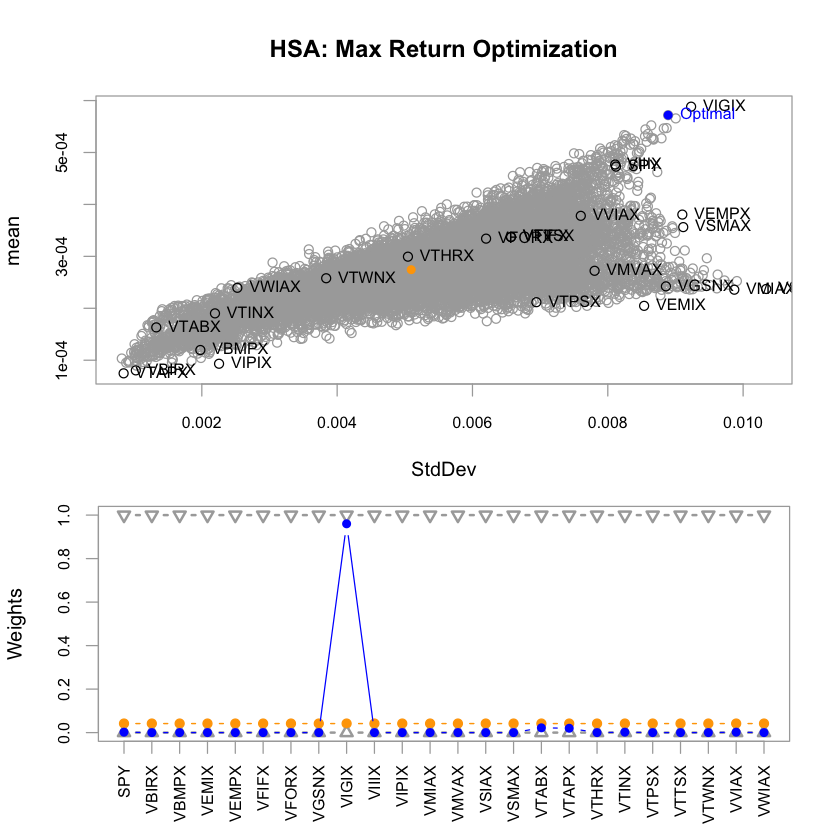

In [15]:
# Optimize PF  
opt_hsa_roi = optimize.portfolio(R=hsaRet, portfolio = p, optimize_method = 'ROI', trace = TRUE)
  opt_hsa_roi

# Plot the chart
    plot(opt_pf, risk.col="StdDev", return.col="mean", main="HSA: Max Return Optimization", chart.assets=TRUE)  #%>% ggplot()


### Find Optomal weights by Generation of Random 

In [17]:
opt_hsa_rn = optimize.portfolio(R = hsaRet, portfolio = p, optimize_method = 'random',rp = random_portfolios(p, 5000, 'sample'), trace = TRUE)
opt_hsa_rn

***********************************
PortfolioAnalytics Optimization
***********************************

Call:
optimize.portfolio(R = hsaRet, portfolio = p, optimize_method = "random", 
    trace = TRUE, rp = random_portfolios(p, 5000, "sample"))

Optimal Weights:
  SPY VBIRX VBMPX VEMIX VEMPX VFIFX VFORX VGSNX VIGIX VIIIX VIPIX VMIAX VMVAX 
0.074 0.000 0.058 0.000 0.002 0.174 0.000 0.000 0.000 0.004 0.000 0.000 0.020 
VSIAX VSMAX VTABX VTAPX VTHRX VTINX VTPSX VTTSX VTWNX VVIAX VWIAX 
0.000 0.000 0.674 0.000 0.000 0.000 0.000 0.004 0.000 0.000 0.000 

Objective Measures:
 StdDev 
0.00201 


     mean 
0.0002352 




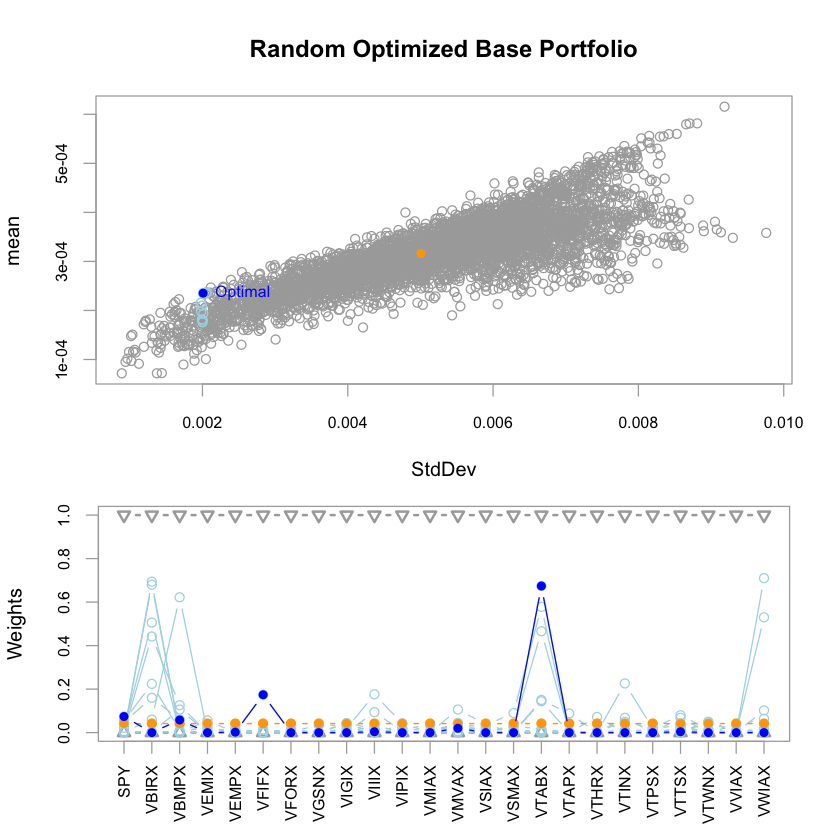

In [19]:
plot(opt_hsa_rn, main = 'Random Optimized Base Portfolio',risk.col = 'StdDev', neighbors = 10)

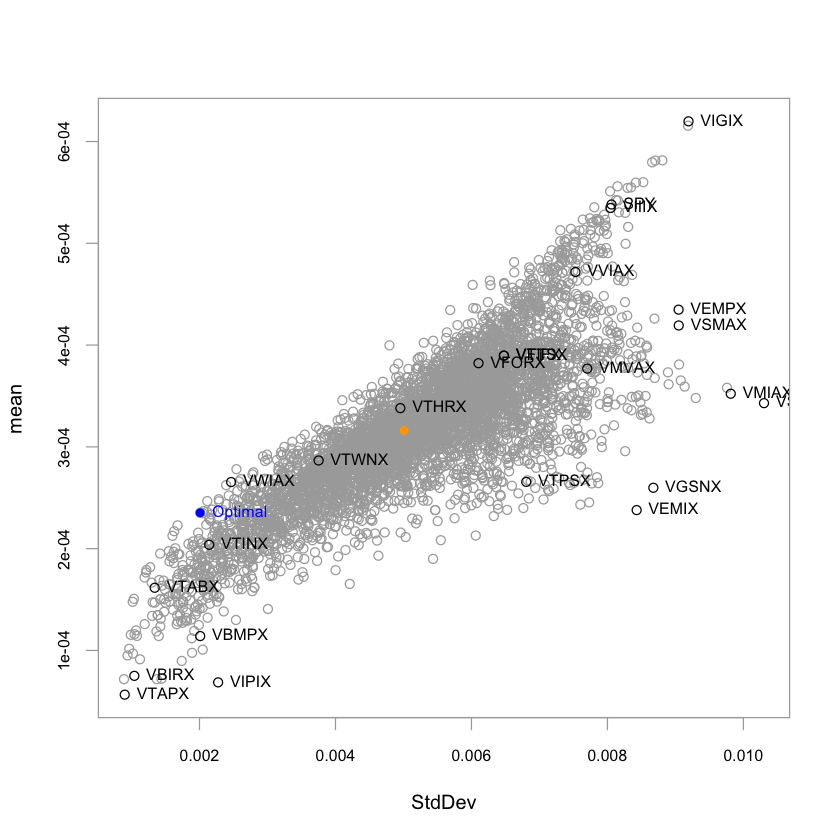

In [23]:
chart.RiskReward(opt_hsa_rn, chart.assets = TRUE,return.col = "mean", risk.col = "StdDev")


In [31]:

hsa_ef = create.EfficientFrontier( R = hsaRet,  portfolio = p ,  type = "mean-sd", n.portfolios = 25, )
hsa_ef

**************************************************
PortfolioAnalytics Efficient Frontier 
**************************************************

Call:
create.EfficientFrontier(R = hsaRet, portfolio = p, type = "mean-sd", 
    n.portfolios = 25)

Efficient Frontier Points: 24 

**************************************************
PortfolioAnalytics Portfolio Specification 
**************************************************

Call:
portfolio.spec(assets = colnames(hsaRet))

Number of assets: 28 
Asset Names
 [1] "BND"   "BNDX"  "SPY"   "VBIRX" "VBMPX" "VEMIX" "VEMPX" "VFIFX" "VFORX"
[10] "VGSNX"
More than 10 assets, only printing the first 10

Constraints
Enabled constraint types
		- weight_sum 
		- long_only 

Objectives:
Enabled objective names
		- mean 
		- StdDev 


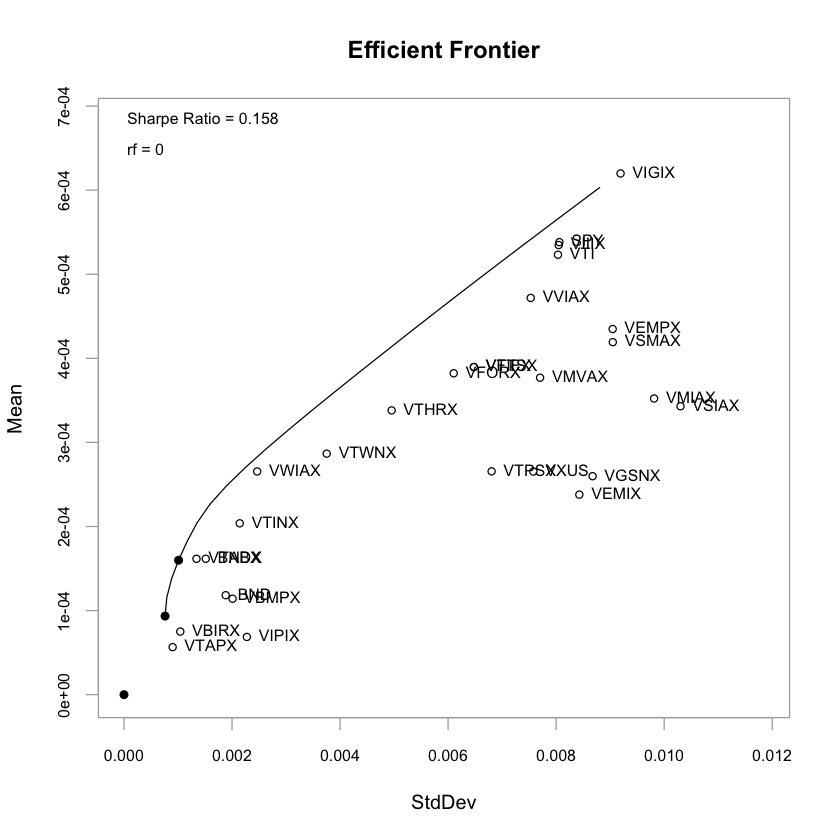

In [32]:
chart.EfficientFrontier(hsa_ef,
                        match.col="StdDev", # which column to use for risk
                        type="l", 
                        RAR.text="Sharpe Ratio",
                        tangent.line = FALSE,
                        chart.assets=TRUE,
                        labels.assets=TRUE)